In [1]:
import pystan
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import pandas as pd

In [8]:
data_pd = np.array(pd.read_csv("historical_returns.csv").iloc[0][1:])

In [5]:
# Implementing GJR GARCH model
graph = """
data {
    int<lower = 1> N;
    real r_s[N];
    real<lower = 0> sigma0;
}
parameters {
    real b0;
    real b1;
    real<lower = 0, upper = 1> w;
    real<lower = 0, upper = 1> beta;
    real<lower = 0, upper = 1> alpha;
    real<lower = 0, upper = 1> gamma;
}
transformed parameters {
    real err[N-1];
    real<lower = 0> sigmas[N];
    sigmas[1] = sigma0;
    for (i in 2:N){
        err[i-1] = r_s[i] - b0 - b1 * r_s[i-1];
        sigmas[i] = sqrt(w + beta * pow(sigmas[i-1],2)+ (alpha + gamma * (err[i-1] < 0)) * pow(err[i-1],2));
    }
}
model {
    r_s[1] ~ normal(b0, sigma0);
    for (i in 2:N) {
        r_s[i] ~ normal(b0 + b1 * r_s[i-1], sigmas[i]);
    }
    b0 ~ normal(0, 1);
    b1 ~ normal(0, 100);
}
"""

In [6]:
sm = pystan.StanModel(model_code = graph)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6767e047e09aafdca146e1e71802646d NOW.


In [9]:
vol_dat = {'N': data_pd.size,
'r_s': list(data_pd),
'sigma0': 0.02}

In [10]:
fit = sm.sampling(vol_dat, iter = 1000)

C:\Users\Edgar\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [11]:
found_sigmas = fit['sigmas'].T.mean(axis = 1)

In [12]:
prices = np.ones_like(data_pd)
for i in range(1, prices.size):
    prices[i] = np.exp(data_pd[i-1]) * prices[i-1]

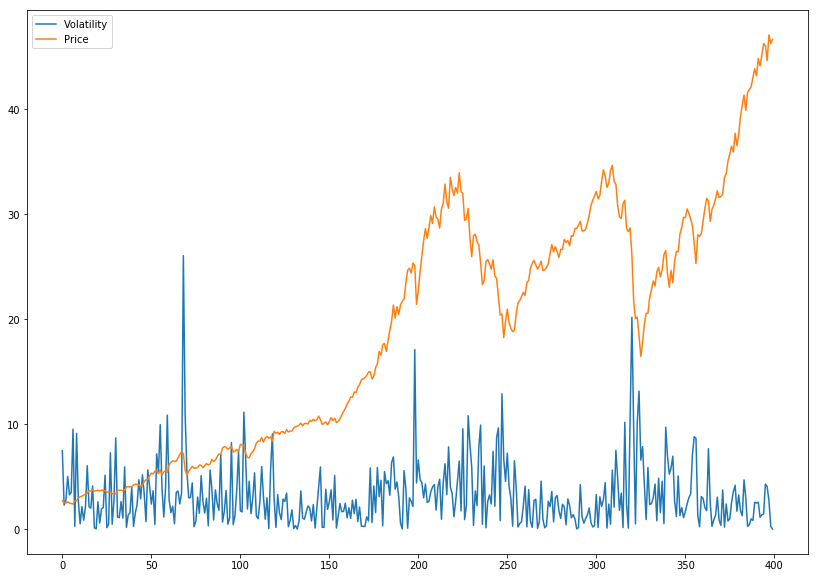

In [13]:
M = 300
N = 400

plt.figure(figsize = (14,10))
plt.plot(range(N), found_sigmas[M:N+M] * 100, label = "Volatility")
plt.plot(range(N), prices[M:N+M], label = "Price")
plt.legend()
plt.savefig("price_volatility_gjr.jpg")